In [1]:
import pandas as pd
import glob
import xarray as xr
import numpy as np
from statsmodels.stats.anova import AnovaRM 
from scipy import stats
from matplotlib import pyplot as plt
import pingouin as pg
import numpy as np
import seaborn as sns
import scipy

ModuleNotFoundError: No module named 'scikit_posthocs'

In [2]:
vn = ['fusiform-rh', 'fusiform-lh', 'lingual-lh', 'lingual-rh',
'cuneus-rh','cuneus-lh', 'lateraloccipital-rh', 'lateraloccipital-lh']

methods = ['coh','ciplv','imcoh','wpli2']

In [3]:
#intra-subject variance

intra_variance_dict = {}
for method in methods: 
    subject_files = glob.glob(f'/Users/lina_01/Desktop/mpi_lemon/undirected_outputs/{method}/*_EC.nc')
    variance_per_subject = []
    for file in subject_files:
        xarray = xr.open_dataarray(file)
        std_mean_list = []
        for sample in range(0,100):
            std = xarray.sel(bootstrap_samples=sample, region1=vn, region2=vn).values.std()
            mean = xarray.sel(bootstrap_samples=sample, region1=vn, region2=vn).values.mean()
            std_mean_list.append(mean)
        variance_per_subject.append(np.std(std_mean_list)**2)
    intra_variance_dict[method] = variance_per_subject

In [9]:
#Inter-subject variance

inter_variance_dict = {}
for method in methods:
    subject_files = glob.glob(f'/Users/lina_01/Desktop/mpi_lemon/undirected_outputs/{method}/*_EC.nc')
    all_bootstraps = []  #list of 11200 arrays
    for file in subject_files:
        xarray = xr.open_dataarray(file)
        for sample in range(0,100):
            bootstrap = xarray.sel(bootstrap_samples=sample, region1=vn, region2=vn).values
            all_bootstraps.append(bootstrap)
    
    random_bootstraps = []
    for i in range(0,112):
        index = np.random.choice(range(0,11200),100)
        sample = np.array(all_bootstraps)[index,:]
        random_bootstraps.append(sample)

    variance_per_bootstrap = []
    for sample in random_bootstraps:
        variance = sample.std()
        variance_per_bootstrap.append(variance)

    inter_variance_dict[method] = variance_per_bootstrap

In [10]:
#comparing inter- and intra-variance for each method
p_vals = {}
eff_size = {}
for method in methods:
    p_val = stats.ranksums(inter_variance_dict[method], intra_variance_dict[method])[1]
    
    n1 = len(inter_variance_dict[method])
    n2 = len(intra_variance_dict[method])
    sd1 = np.std(inter_variance_dict[method])
    sd2 = np.std(intra_variance_dict[method])

    mean1 = np.mean(inter_variance_dict[method])
    mean2 = np.mean(intra_variance_dict[method])

    pooled_sd = np.sqrt((((n1-1)*(sd1**2))+((n2-1)*(sd2**2)))/(n1+n2-2))

    cohens_d = (mean1 - mean2) / pooled_sd

    p_vals[method] = p_val
    eff_size[method] = cohens_d

In [11]:
##CHECK STATISTICAL TEST ASSUMPTIONS FOR ANOVA
#normal distribution
stats.shapiro(intra_variance_dict['coh'])

ShapiroResult(statistic=0.5364351868629456, pvalue=3.487929475560499e-17)

In [12]:
#homogeneity of variance 
stats.levene(inter_variance_dict['wpli2'], inter_variance_dict['ciplv'], inter_variance_dict['coh'], inter_variance_dict['imcoh'])

LeveneResult(statistic=38.219632505148766, pvalue=5.478542551721322e-22)

In [13]:
#compare inter-variance across methods
stats.kruskal(inter_variance_dict['coh'], inter_variance_dict['ciplv'], inter_variance_dict['imcoh'], inter_variance_dict['wpli2'])


KruskalResult(statistic=417.9227094791149, pvalue=2.9024197618762464e-90)

In [14]:
#compare intra-variance across methods
stats.kruskal(intra_variance_dict['coh'], intra_variance_dict['ciplv'], intra_variance_dict['imcoh'], intra_variance_dict['wpli2'])


KruskalResult(statistic=214.4167505880414, pvalue=3.232772171265689e-46)

In [29]:
#post-hoc 1
stats.dunnett(np.array(intra_variance_dict['wpli2']), np.array(intra_variance_dict['ciplv']), np.array(intra_variance_dict['imcoh']), control=intra_variance_dict['coh'])


DunnettResult(statistic=array([ 0.61759998,  6.14165444, -5.638013  ]), pvalue=array([8.70785510e-01, 5.04115139e-09, 8.38514809e-08]))

In [30]:
#post-hoc 2
stats.dunnett(np.array(intra_variance_dict['coh']), np.array(intra_variance_dict['wpli2']), np.array(intra_variance_dict['imcoh']), control=intra_variance_dict['ciplv'])


DunnettResult(statistic=array([ -6.14165444,  -5.52405446, -11.77966744]), pvalue=array([4.45174342e-09, 1.68397960e-07, 0.00000000e+00]))

In [31]:
#post-hoc 3
stats.dunnett(np.array(intra_variance_dict['coh']), np.array(intra_variance_dict['ciplv']), np.array(intra_variance_dict['wpli2']), control=intra_variance_dict['imcoh'])


DunnettResult(statistic=array([ 5.638013  , 11.77966744,  6.25561298]), pvalue=array([7.93634751e-08, 0.00000000e+00, 2.47917142e-09]))

In [28]:
#post-hoc 4
stats.dunnett(np.array(intra_variance_dict['coh']), np.array(intra_variance_dict['ciplv']), np.array(intra_variance_dict['imcoh']), control=intra_variance_dict['wpli2'])

DunnettResult(statistic=array([-0.61759998,  5.52405446, -6.25561298]), pvalue=array([8.70797445e-01, 1.45767620e-07, 1.86393179e-09]))

/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1469/134838794.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(inter_variance_dict['coh'], hist=False, label='coh')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1469/134838794.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in sea

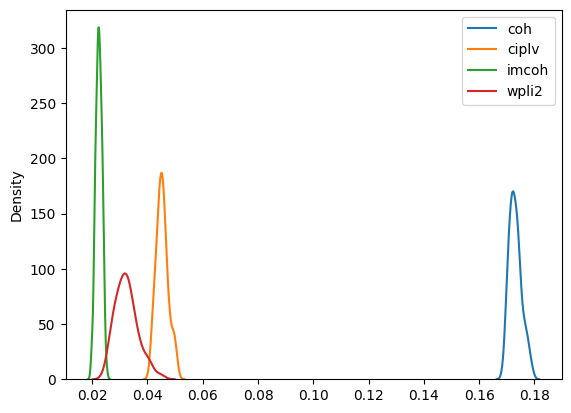

In [32]:
#visualize inter variances across methods
sns.distplot(inter_variance_dict['coh'], hist=False, label='coh')
sns.distplot(inter_variance_dict['ciplv'], hist=False, label='ciplv')
sns.distplot(inter_variance_dict['imcoh'], hist=False, label='imcoh')
sns.distplot(inter_variance_dict['wpli2'], hist=False, label='wpli2')
plt.legend()

/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1469/1043368866.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(intra_variance_dict['coh'], hist=False, label='coh')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1469/1043368866.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in s

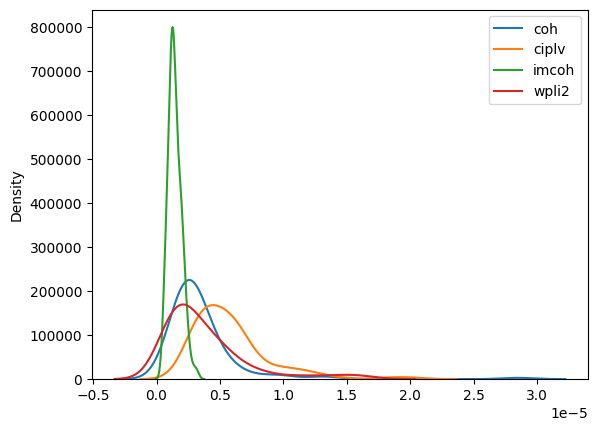

In [8]:
#visualize intra variances across methods
sns.distplot(intra_variance_dict['coh'], hist=False, label='coh')
sns.distplot(intra_variance_dict['ciplv'], hist=False, label='ciplv')
sns.distplot(intra_variance_dict['imcoh'], hist=False, label='imcoh')
sns.distplot(intra_variance_dict['wpli2'], hist=False, label='wpli2')
plt.legend()